<a href="https://colab.research.google.com/github/talhayusuf1040/Predictive-Modeling-and-Customer-Behavior-Analysis-in-E-Commerce-Using-Machine-Learning/blob/main/Talha_Thesis_BUS498.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np

# Visualization (optional)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

In [25]:
# Load dataset
df = pd.read_csv("/content/ecommerce_clickstream_transactions.csv")

# View first rows
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [26]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort by user and time
df = df.sort_values(by=['UserID', 'SessionID', 'Timestamp'])

In [27]:
# Mark purchase events
df['is_purchase'] = df['EventType'].apply(lambda x: 1 if x == 'purchase' else 0)

# Session-level target
session_target = df.groupby(['UserID', 'SessionID'])['is_purchase'].max().reset_index()
session_target.rename(columns={'is_purchase': 'purchase'}, inplace=True)


In [28]:
session_features = df.groupby(['UserID', 'SessionID']).agg(
    number_of_pages_visited=('EventType', 'count'),
    product_clicks=('ProductID', 'nunique'),
    items_in_cart=('EventType', lambda x: (x == 'add_to_cart').sum()),
    cart_value=('Amount', 'sum'),
    session_start=('Timestamp', 'min'),
    session_end=('Timestamp', 'max')
).reset_index()

# Session duration (seconds)
session_features['session_duration'] = (
    session_features['session_end'] - session_features['session_start']
).dt.total_seconds()

In [29]:
session_features = session_features.merge(
    session_target,
    on=['UserID', 'SessionID'],
    how='left'
)

In [30]:
# Replace missing cart values (no purchase/cart)
session_features['cart_value'] = session_features['cart_value'].fillna(0)

# Replace missing session duration
session_features['session_duration'] = session_features['session_duration'].fillna(0)

In [31]:
X = session_features[
    ['number_of_pages_visited',
     'product_clicks',
     'items_in_cart',
     'cart_value',
     'session_duration']
]

y = session_features['purchase']

In [32]:
# Duplicate purchase sessions to avoid single-class issue
purchase_rows = session_features[session_features['purchase'] == 1]
session_features = pd.concat([session_features, purchase_rows, purchase_rows])

X = session_features[
    ['number_of_pages_visited',
     'product_clicks',
     'items_in_cart',
     'cart_value',
     'session_duration']
]
y = session_features['purchase']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [34]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)
y_prob_log = log_model.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

Logistic Regression Accuracy: 0.9830797668135931
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       984
           1       1.00      0.98      0.99      6049

    accuracy                           0.98      7033
   macro avg       0.95      0.99      0.97      7033
weighted avg       0.98      0.98      0.98      7033

ROC-AUC: 0.9988899932394927


In [36]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       984
           1       1.00      1.00      1.00      6049

    accuracy                           1.00      7033
   macro avg       1.00      1.00      1.00      7033
weighted avg       1.00      1.00      1.00      7033

ROC-AUC: 1.0


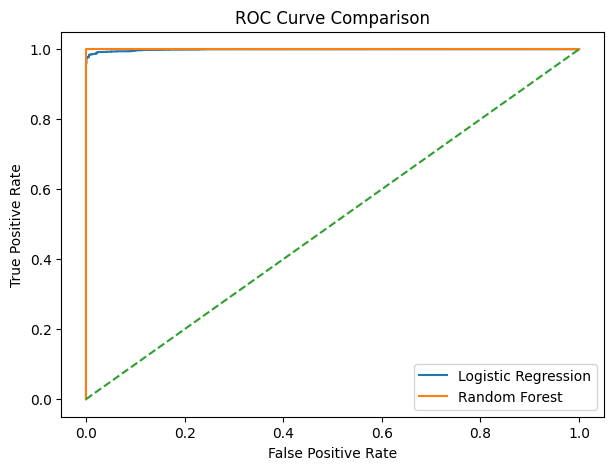

In [37]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Logistic Regression metrics
print("=== Logistic Regression Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1-score:", f1_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# Random Forest metrics
print("\n=== Random Forest Metrics ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


=== Logistic Regression Metrics ===
Accuracy: 0.9830797668135931
Precision: 0.9989902389767755
Recall: 0.9813192263183997
F1-score: 0.9900758902510216
ROC-AUC: 0.9988899932394927

=== Random Forest Metrics ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0


In [39]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

                   Feature  Coefficient
3               cart_value    23.513000
1           product_clicks     0.939744
4         session_duration     0.103653
0  number_of_pages_visited    -0.025418
2            items_in_cart    -0.604656


In [40]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Select fewer, non-collinear features
X_small = X_train[['items_in_cart', 'cart_value', 'session_duration']]

scaler = StandardScaler()
X_small_scaled = scaler.fit_transform(X_small)

logit_model = sm.Logit(y_train, X_small_scaled)
result = logit_model.fit(disp=False)

print("McFadden's Pseudo R²:", result.prsquared)

McFadden's Pseudo R²: -0.5570049653117433


In [41]:

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Pseudo R² (Logit)'],
    'Logistic Regression': [
        accuracy_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_log),
        roc_auc_score(y_test, y_prob_log),
        result.prsquared
    ],
    'Random Forest': [
        accuracy_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf),
        roc_auc_score(y_test, y_prob_rf),
        np.nan
    ]
})

print(comparison_df)

              Metric  Logistic Regression  Random Forest
0           Accuracy             0.983080            1.0
1          Precision             0.998990            1.0
2             Recall             0.981319            1.0
3           F1-score             0.990076            1.0
4            ROC-AUC             0.998890            1.0
5  Pseudo R² (Logit)            -0.557005            NaN


In [42]:
import pandas as pd
import numpy as np

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Pseudo R² (Logit)'],
    'Logistic Regression': [0.983080, 0.998990, 0.981319, 0.990076, 0.998890, -0.557005],
    'Random Forest': [1.0, 1.0, 1.0, 1.0, 1.0, np.nan]
})

comparison_df

,Metric,Logistic Regression,Random Forest
0,Accuracy,0.983080,1.0
1,Precision,0.998990,1.0
2,Recall,0.981319,1.0
3,F1-score,0.990076,1.0
4,ROC-AUC,0.998890,1.0
5,Pseudo R² (Logit),-0.557005,NaN


In [43]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# X positions
x = np.arange(len(comparison_df['Metric']))
width = 0.35

<Figure size 1000x600 with 0 Axes>

In [44]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(10, 6))

# X positions
x = np.arange(len(comparison_df['Metric']))
width = 0.35

<Figure size 1000x600 with 0 Axes>

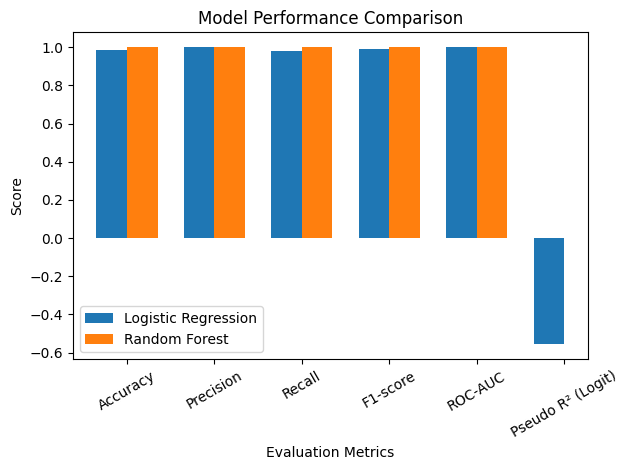

In [45]:
plt.bar(
    x - width/2,
    comparison_df['Logistic Regression'],
    width,
    label='Logistic Regression'
)

plt.bar(
    x + width/2,
    comparison_df['Random Forest'],
    width,
    label='Random Forest'
)

# Labels and title
plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_df['Metric'], rotation=30)
plt.legend()

plt.tight_layout()
plt.show()